# This notebook is for use on cloud services where interactive use of matplotlib is hard. A script similar to this notebook is in in: snpe/marketplace_simulator_analysis.py

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Just a formatting related plugin
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [4]:
import sys

sys.path.append("../")

<IPython.core.display.Javascript object>

In [5]:
import multiprocessing as mp

from collections import deque
from pathlib import Path
from typing import Dict, Optional

import arviz

import numpy as np
import pandas as pd
import pyreadr
import sbi
import sbi.utils as sbi_utils
import seaborn as sns
import statsmodels.formula.api as smf
import torch

from joblib import Parallel, delayed
from matplotlib.lines import Line2D
from scipy.stats import ttest_ind
from snpe.inference import inference_class
from snpe.simulations import simulator_class
from snpe.utils.statistics import review_histogram_correlation
from snpe.utils.tqdm_utils import tqdm_joblib
from tqdm import tqdm

# Set plotting parameters
sns.set(style="white", context="talk", font_scale=2.5)
sns.set_color_codes(palette="colorblind")
sns.set_style("ticks", {"axes.linewidth": 2.0})

<IPython.core.display.Javascript object>

In [6]:
# ARTIFACT_PATH = Path("../../../gcs_mount/artifacts/marketplace")
ARTIFACT_PATH = Path("/data/reputation-systems/snpe/artifacts/marketplace")

<IPython.core.display.Javascript object>

# Functions

In [7]:
def generate_and_save_simulations(
    num_simulations: int,
    review_prior: np.array,
    tendency_to_rate: float,
    simulation_type: str,
    previous_rating_measure: str,
    min_reviews_for_herding: int,
    herding_differentiating_measure: str,
) -> None:
    params = {
        "review_prior": review_prior,
        "tendency_to_rate": tendency_to_rate,
        "simulation_type": simulation_type,
        "previous_rating_measure": previous_rating_measure,
        "min_reviews_for_herding": min_reviews_for_herding,
        "herding_differentiating_measure": herding_differentiating_measure,
    }
    simulator = simulator_class.DoubleHerdingSimulator(params)
    simulator.simulate(num_simulations=num_simulations)
    simulator.save_simulations(ARTIFACT_PATH)

<IPython.core.display.Javascript object>

In [8]:
def infer_and_save_posterior(
    device: str, simulator_type: str, simulation_type: str, params: Dict
) -> None:
    parameter_prior = sbi_utils.BoxUniform(
        low=torch.tensor([0.0, 0.0, 0.0]).type(torch.FloatTensor),
        high=torch.tensor([4.0, 4.0, 1.0]).type(torch.FloatTensor),
        device=device,
    )
    inferrer = inference_class.TimeSeriesInference(
        parameter_prior=parameter_prior, device=device
    )
    inferrer.load_simulator(
        dirname=ARTIFACT_PATH,
        simulator_type=simulator_type,
        simulation_type=simulation_type,
    )
    batch_size = params.pop("batch_size")
    learning_rate = params.pop("learning_rate")
    hidden_features = params.pop("hidden_features")
    num_transforms = params.pop("num_transforms")
    inferrer.infer_snpe_posterior(
        embedding_net_conf=params,
        batch_size=batch_size,
        learning_rate=learning_rate,
        hidden_features=hidden_features,
        num_transforms=num_transforms,
    )
    inferrer.save_inference(ARTIFACT_PATH)

<IPython.core.display.Javascript object>

In [21]:
def sample_posterior_with_observed(
    device: str,
    observations: np.array,
    num_samples: int,
    simulator_type: str,
    simulation_type: str,
) -> np.array:
    # The parameter prior doesn't matter here as it will be overridden by that of the loaded inference object
    parameter_prior = sbi.utils.BoxUniform(
        low=torch.tensor([0.0, 0.0, 0.0]).type(torch.FloatTensor),
        high=torch.tensor([4.0, 4.0, 1.0]).type(torch.FloatTensor),
        device=device,
    )
    inferrer = inference_class.TimeSeriesInference(
        parameter_prior=parameter_prior, device=device
    )
    inferrer.load_simulator(
        dirname=ARTIFACT_PATH,
        simulator_type=simulator_type,
        simulation_type=simulation_type,
    )
    inferrer.load_inference(dirname=ARTIFACT_PATH)
    posterior_samples = inferrer.get_posterior_samples(
        observations, num_samples=num_samples
    )
    return posterior_samples

<IPython.core.display.Javascript object>

In [9]:
def plot_mean_posteriors_for_products(posterior_samples: np.ndarray) -> None:
    fig, ax = plt.subplots(1, 2, squeeze=False)
    ax[0, 0].hist(
        np.mean(posterior_samples[:, :, 0], axis=0),
        color=sns.xkcd_rgb["cerulean"],
        alpha=0.5,
        bins=10,
        label=r"$\rho_{-}$",
    )
    ax[0, 0].hist(
        np.mean(posterior_samples[:, :, 1], axis=0),
        color=sns.xkcd_rgb["dark orange"],
        alpha=0.5,
        bins=10,
        label=r"$\rho_{+}$",
    )
    ax[0, 1].hist(
        np.mean(posterior_samples[:, :, 2], axis=0),
        color=sns.xkcd_rgb["black"],
        alpha=0.5,
        bins=10,
        label=r"$h_p$",
    )
    ax[0, 0].legend(fontsize=20)
    ax[0, 1].legend(fontsize=20)
    ax[0, 0].set_xticks([0, 1, 2, 3, 4])
    ax[0, 1].set_xticks([0, 0.5, 1])
    ax[0, 0].tick_params(axis="both", labelsize=23)
    ax[0, 1].tick_params(axis="both", labelsize=23)
    # add a big axis, hide frame
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)
    # plt.xlabel(r"$\rho_{-}, \rho_{+}$")
    plt.ylabel(
        f"Number of products (Total = {posterior_samples.shape[1]})", fontsize=28
    )
    fig.savefig(ARTIFACT_PATH / "mean_posteriors.png", bbox_inches="tight")

<IPython.core.display.Javascript object>

# Actual code to run the functions above

In [8]:
torch.set_num_threads(mp.cpu_count())
torch.get_num_threads()

16

<IPython.core.display.Javascript object>

In [16]:
inference_params = {
    "batch_size": 128,
    "learning_rate": 1.9e-4,
    "hidden_features": 35,
    "num_transforms": 5,
    "num_conv_layers": 2,
    "num_channels": 10,
    "conv_kernel_size": 5,
    "maxpool_kernel_size": 9,
    "num_dense_layers": 1,
}

<IPython.core.display.Javascript object>

In [17]:
infer_and_save_posterior("cuda", "marketplace", "timeseries", inference_params)

Embedding net created: 
 Sequential(
  (0): Conv1d(5, 10, kernel_size=(5,), stride=(1,), padding=(2,))
  (1): LeakyReLU(negative_slope=0.01)
  (2): Conv1d(10, 10, kernel_size=(5,), stride=(1,), padding=(4,), dilation=(2,))
  (3): MaxPool1d(kernel_size=9, stride=9, padding=0, dilation=1, ceil_mode=False)
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=740, out_features=32, bias=True)
)


/opt/conda/lib/python3.7/site-packages/sbi/utils/user_input_checks.py:684: UserWarning: Data x has device 'cpu' different from the training_device 'cuda:0', moving x to the training_device 'cuda:0'.
  f"Data x has device '{x.device}' "
/opt/conda/lib/python3.7/site-packages/sbi/utils/user_input_checks.py:692: UserWarning: Parameters theta has device 'cpu' different from the training_device 'cuda:0', moving theta to the training_device 'cuda:0'.
  f"Parameters theta has device '{theta.device}' "
/opt/conda/lib/python3.7/site-packages/sbi/utils/user_input_checks.py:428: UserWarning: Mismatch between the device of the data fed to the embedding_net and the device of the embedding_net's weights. Fed data has device 'cuda:0' vs embedding_net weights have device 'cpu'. Automatically switching the embedding_net's device to 'cuda:0', which could otherwise be done manually using the line `embedding_net.to('cuda:0')`.
  "Mismatch between the device of the data fed "


 Neural network successfully converged after 234 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 234
        Best validation performance: 1.0422
        -------------------------
        


<IPython.core.display.Javascript object>

# Working with the observed data

In [7]:
# reviews = pyreadr.read_r(
#    "/data/Dropbox/SNPE/all_data/reviews_bazaarvoice_main_vars.Rds"
# )
reviews = pyreadr.read_r(ARTIFACT_PATH / "reviews_bazaarvoice_main_vars.Rds")
reviews = reviews[None]
reviews.head()

,asin,overall,ReviewId,unixReviewTime,rootcategoryid
0,670155,4,3480905,2009-02-10,33005908
1,670155,3,3535864,2009-02-24,33005908
2,670155,5,3539112,2009-02-24,33005908
3,670155,4,3539514,2009-02-25,33005908
4,670155,1,3556157,2009-03-05,33005908


<IPython.core.display.Javascript object>

In [8]:
pd.testing.assert_frame_equal(reviews, reviews.sort_values(["asin", "unixReviewTime"]))

<IPython.core.display.Javascript object>

In [9]:
reviews.asin.value_counts().max()

1293

<IPython.core.display.Javascript object>

In [10]:
reviews.asin.unique().shape

(1406,)

<IPython.core.display.Javascript object>

In [11]:
# Pull out the ratings from the timeseries DF and convert them into a format
# that can be fed into the inference engine
timeseries_data = []
for product in reviews.asin.unique():
    # We were cutting off at 5001 reviews earlier when we could control the number of reviews per product in the sims
    # But now, we put the max len of the deque a little higher than the number of reviews
    # for the most reviewed product (around 1300)
    timeseries = deque([np.zeros(5)], maxlen=673)
    ratings = np.array(reviews.loc[reviews.asin == product, "overall"])
    ratings = ratings[:673]
    for rating in ratings:
        current_histogram = timeseries[-1].copy()
        current_histogram[int(rating - 1)] += 1
        timeseries.append(current_histogram)
    timeseries_data.append(np.array(timeseries))
timeseries_data = np.array(timeseries_data, dtype="object")

<IPython.core.display.Javascript object>

In [31]:
timeseries_data.shape

(1406,)

<IPython.core.display.Javascript object>

In [32]:
posterior_samples = sample_posterior_with_observed(
    "cuda", timeseries_data, 10_000, "marketplace", "timeseries"
)

/opt/conda/lib/python3.7/site-packages/sbi/utils/torchutils.py:28: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  "GPU was selected as a device for training the neural network. "


<IPython.core.display.Javascript object>

In [33]:
posterior_samples.shape

(10000, 1406, 3)

<IPython.core.display.Javascript object>

In [35]:
np.save(ARTIFACT_PATH / "posterior_samples_bazaarvoice.npy", posterior_samples)

<IPython.core.display.Javascript object>

# Plotting the posterior samples

In [7]:
posterior_samples = np.load(ARTIFACT_PATH / "posterior_samples_bazaarvoice.npy")
posterior_samples.shape

(10000, 1406, 3)

<IPython.core.display.Javascript object>

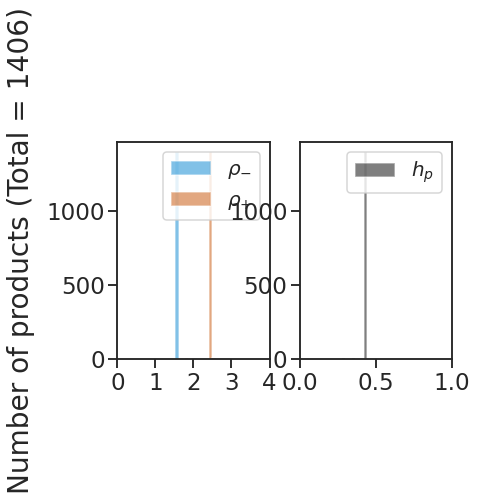

<IPython.core.display.Javascript object>

In [10]:
plot_mean_posteriors_for_products(posterior_samples)

(array([  4.,  41., 207., 457., 455., 190.,  38.,   4.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          4.]),
 array([1.52702405, 1.53518252, 1.54334099, 1.55149946, 1.55965793,
        1.56781639, 1.57597486, 1.58413333, 1.5922918 , 1.60045027,
        1.60860874, 1.6167672 , 1.62492567, 1.63308414, 1.64124261,
        1.64940108, 1.65755955, 1.66571801, 1.67387648, 1.68203495,
        1.69019342, 1.69835189, 1.70651036, 1.

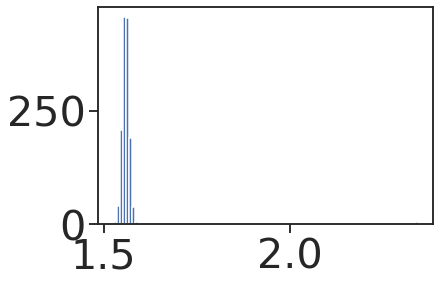

<IPython.core.display.Javascript object>

In [14]:
plt.hist(np.mean(posterior_samples[:, :, 0], axis=0), bins=100)

In [13]:
np.mean(posterior_samples[:, :, 0], axis=0)

array([1.54695524, 1.55164593, 1.56308243, ..., 1.55218146, 1.56293319,
       1.56575715])

<IPython.core.display.Javascript object>

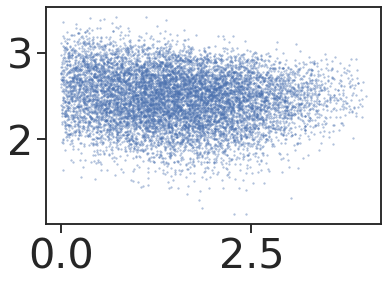

<IPython.core.display.Javascript object>

In [15]:
plt.scatter(posterior_samples[:, 10, 0], posterior_samples[:, 10, 1], alpha=0.5, s=0.5)

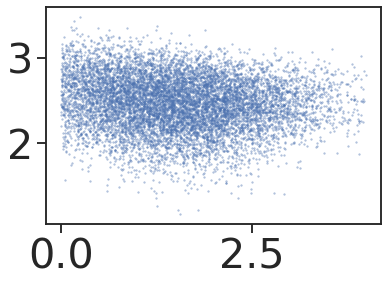

<IPython.core.display.Javascript object>

In [16]:
plt.scatter(posterior_samples[:, 1000, 0], posterior_samples[:, 1000, 1], alpha=0.5, s=0.5)

(array([  19.,   39.,   85.,  151.,  306.,  562.,  884., 1331., 1517.,
        1555., 1276.,  928.,  587.,  389.,  181.,   93.,   61.,   23.,
          10.,    3.]),
 array([0.00118669, 0.04894638, 0.09670607, 0.14446576, 0.19222545,
        0.23998514, 0.28774483, 0.33550452, 0.38326421, 0.4310239 ,
        0.47878359, 0.52654328, 0.57430297, 0.62206266, 0.66982235,
        0.71758204, 0.76534173, 0.81310142, 0.86086111, 0.9086208 ,
        0.95638049]),
 <BarContainer object of 20 artists>)

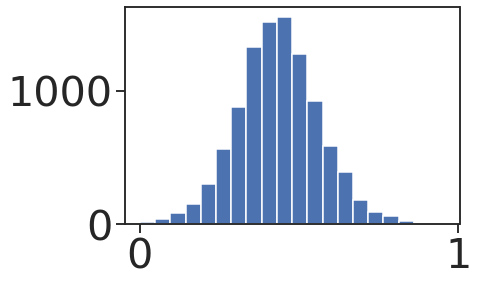

<IPython.core.display.Javascript object>

In [19]:
plt.hist(posterior_samples[:, 700, 2], bins=20)

<AxesSubplot:>

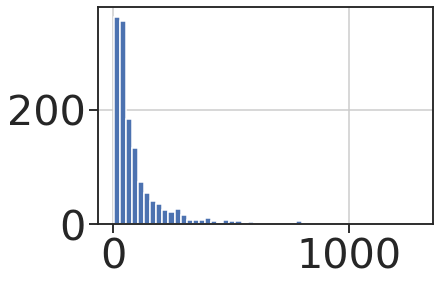

<IPython.core.display.Javascript object>

In [25]:
reviews.asin.value_counts().hist(bins=50)

In [26]:
reviews.asin.value_counts().describe()

count    1406.000000
mean       96.212660
std       126.677148
min         1.000000
25%        25.250000
50%        51.000000
75%       113.000000
max      1293.000000
Name: asin, dtype: float64

<IPython.core.display.Javascript object>

In [28]:
counts = reviews.asin.value_counts().rename_axis("asin").reset_index(name="counts")

<IPython.core.display.Javascript object>

In [29]:
counts

,asin,counts
0,8505590,1293
1,4251831,1224
2,4201386,973
3,6510154,876
4,4007573,797
...,...,...
1401,9152069,1
1402,2445546,1
1403,5190331,1
1404,5190290,1


<IPython.core.display.Javascript object>

In [36]:
counts.asin[(counts.counts < 650) * (counts.counts > 100)]

10     5323249
11     8407045
12     9010390
13     8500296
14     1270743
        ...   
390    2816436
391    9068775
392    4327411
393     670155
394    1279074
Name: asin, Length: 385, dtype: int64

<IPython.core.display.Javascript object>

In [41]:
np.where(reviews.asin.unique() == 1279074)

(array([200]),)

<IPython.core.display.Javascript object>

(array([1.000e+00, 1.000e+00, 3.000e+00, 6.000e+00, 3.400e+01, 8.800e+01,
        1.740e+02, 3.390e+02, 6.280e+02, 9.290e+02, 1.261e+03, 1.426e+03,
        1.515e+03, 1.296e+03, 1.073e+03, 7.190e+02, 3.310e+02, 1.230e+02,
        4.100e+01, 1.200e+01]),
 array([1.00311565, 1.12505956, 1.24700346, 1.36894736, 1.49089127,
        1.61283517, 1.73477907, 1.85672297, 1.97866688, 2.10061078,
        2.22255468, 2.34449859, 2.46644249, 2.58838639, 2.7103303 ,
        2.8322742 , 2.9542181 , 3.076162  , 3.19810591, 3.32004981,
        3.44199371]),
 <BarContainer object of 20 artists>)

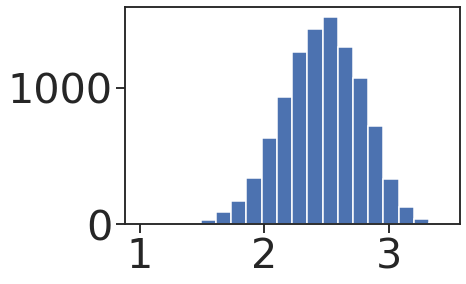

<IPython.core.display.Javascript object>

In [43]:
plt.hist(posterior_samples[:, 200, 1], bins=20)

In [14]:
timeseries_data[1300]

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  2.],
       [ 0.,  0.,  0.,  0.,  3.],
       [ 0.,  0.,  0.,  0.,  4.],
       [ 0.,  0.,  0.,  0.,  5.],
       [ 0.,  0.,  0.,  0.,  6.],
       [ 0.,  0.,  0.,  0.,  7.],
       [ 0.,  0.,  0.,  0.,  8.],
       [ 0.,  0.,  0.,  1.,  8.],
       [ 0.,  0.,  0.,  1.,  9.],
       [ 0.,  0.,  0.,  1., 10.],
       [ 0.,  0.,  0.,  1., 11.],
       [ 1.,  0.,  0.,  1., 11.],
       [ 1.,  0.,  0.,  1., 12.],
       [ 1.,  0.,  0.,  1., 13.],
       [ 1.,  0.,  0.,  1., 14.],
       [ 1.,  0.,  1.,  1., 14.],
       [ 1.,  0.,  1.,  1., 15.],
       [ 1.,  0.,  1.,  2., 15.],
       [ 1.,  0.,  2.,  2., 15.],
       [ 1.,  0.,  2.,  3., 15.],
       [ 1.,  0.,  2.,  3., 16.],
       [ 1.,  0.,  2.,  3., 17.],
       [ 1.,  1.,  2.,  3., 17.],
       [ 1.,  1.,  2.,  4., 17.],
       [ 1.,  1.,  2.,  4., 18.],
       [ 1.,  1.,  2.,  4., 19.],
       [ 1.,  1.,  2.,  5., 19.],
       [ 1.,  

<IPython.core.display.Javascript object>